In [1]:
!pip install -q --upgrade pip
!pip install -q timm albumentations==1.2.1 opencv-python-headless scikit-learn pandas matplotlib kaggle wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.8 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Download HAM10000 Dataset**

In [4]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d /content/ham10000
print("✅ Dataset downloaded and unzipped successfully in main directory!")

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [02:30<00:00, 60.7MB/s]
100% 5.20G/5.20G [02:30<00:00, 37.0MB/s]
✅ Dataset downloaded and unzipped successfully in main directory!


In [19]:
DATA_DIR = "/content/ham10000"

df = pd.read_csv("/content/ham10000/HAM10000_metadata.csv")

print("Metadata file:", meta_file)
print(df.head())


Metadata file: /content/ham10000/HAM10000_metadata.csv
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [62]:
# Colab-ready training script for HAM10000 (PyTorch)
import os
import random
import numpy as np
from glob import glob
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Mixed precision
from torch.cuda.amp import autocast, GradScaler

# ---------- SETTINGS ----------
DATA_DIR = "/content/ham10000"  # update to your mounted dataset
# --- FIX: Define paths for both image folders ---
IMG_DIR_1 = os.path.join(DATA_DIR, "HAM10000_images_part_1")
IMG_DIR_2 = os.path.join(DATA_DIR, "HAM10000_images_part_2")
META_CSV = os.path.join(DATA_DIR, "HAM10000_metadata.csv")  # update if needed
IMG_SIZE = 300                # EfficientNetB3 -> 300
BATCH_SIZE = 16
NUM_WORKERS = 2
SEED = 42
EPOCHS_HEAD = 6
EPOCHS_FINETUNE = 25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "tf_efficientnet_b3_ns"  # timm name (EfficientNet-B3)
NUM_CLASSES = 7
SAVE_PATH = "/content/ham10000_checkpoints"  # optional
os.makedirs(SAVE_PATH, exist_ok=True)
USE_MIXUP = False  # toggle MixUp/CutMix
# ------------------------------

def seed_everything(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

# ------ Load metadata & prepare splits ------
meta = pd.read_csv(META_CSV)
# Ensure the CSV has columns: 'image_id' and 'dx' (diagnosis/class); adjust if different.
# Map classes to numeric labels:
label_map = {k:i for i,k in enumerate(meta['dx'].unique())}
meta['label'] = meta['dx'].map(label_map)
# create train/val split (stratified)
train_df, val_df = train_test_split(meta, test_size=0.2, stratify=meta['label'], random_state=SEED)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# ---------- Dataset ----------
# --- FIX: Modified HAMDataset to check both image directories ---
class HAMDataset(Dataset):
    def __init__(self, df, img_dir1, img_dir2, transforms=None, img_size=IMG_SIZE):
        self.df = df
        self.img_dir1 = img_dir1
        self.img_dir2 = img_dir2
        self.transforms = transforms
        self.img_size = img_size

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['image_id']

        # Construct path for both directories
        path1 = os.path.join(self.img_dir1, img_id + ".jpg")
        path2 = os.path.join(self.img_dir2, img_id + ".jpg")

        # Check which path exists and set the final img_path
        if os.path.exists(path1):
            img_path = path1
        elif os.path.exists(path2):
            img_path = path2
        else:
            # If the image is not found in either directory, raise an error
            raise FileNotFoundError(f"Image not found in {self.img_dir1} or {self.img_dir2} for ID: {img_id}")

        # read with cv2 for albumentations
        import cv2
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"cv2 failed to read image at path: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transforms:
            img = self.transforms(image=img)['image']
        label = int(row['label'])
        return img, label

# ---------- Augmentations ----------
train_transforms = A.Compose([
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.7,1.0), p=0.7),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=0, p=0.4),
    A.CoarseDropout(max_holes=1, max_height=int(IMG_SIZE*0.12), max_width=int(IMG_SIZE*0.12), p=0.3),
    A.Normalize(), ToTensorV2()
])

valid_transforms = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(), ToTensorV2()])

# --- FIX: Pass both image directory paths to the Dataset instances ---
train_ds = HAMDataset(train_df, IMG_DIR_1, IMG_DIR_2, transforms=train_transforms)
val_ds = HAMDataset(val_df, IMG_DIR_1, IMG_DIR_2, transforms=valid_transforms)


# Weighted sampler to address class imbalance
class_counts = train_df['label'].value_counts().sort_index().values
class_weights = 1.0 / (class_counts + 1e-6)
sample_weights = train_df['label'].map(lambda x: class_weights[x]).values
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ---------- Model ----------
def create_model(model_name=MODEL_NAME, n_classes=NUM_CLASSES, pretrained=True):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=n_classes)
    return model

model = create_model().to(DEVICE)

# ---------- Loss, optimizer, scheduler ----------
# class_weights for loss:
cw = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=cw)

# Optimizer and scheduler (use AdamW)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

scaler = GradScaler()

# ---------- Training & Evaluation Helpers ----------
def train_one_epoch(loader, model, optimizer, criterion, device, epoch, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in tqdm(loader, desc=f"Train E{epoch}"):
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def validate(loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    for imgs, labels in tqdm(loader, desc="Val"):
        imgs = imgs.to(device)
        labels = labels.to(device)
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        running_loss += loss.item() * imgs.size(0)
        all_preds.append(outputs.argmax(dim=1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = (all_preds == all_labels).mean()
    report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    macro_f1 = report['macro avg']['f1-score']
    return running_loss/len(loader.dataset), acc, macro_f1, report

# ---------- Train loop (freeze head then fine-tune) ----------
# Freeze backbone: set requires_grad False for base parameters except classifier head
def freeze_backbone(m):
    for name, p in m.named_parameters():
        if 'classifier' not in name and 'head' not in name and 'fc' not in name:
            p.requires_grad = False

def unfreeze_all(m):
    for p in m.parameters(): p.requires_grad = True

# Example: freeze all except final classifier head
try:
    # try common classifier names
    for name, p in model.named_parameters():
        if 'classifier' in name or 'head' in name or 'fc' in name:
            p.requires_grad = True
        else:
            p.requires_grad = False
except:
    pass

best_val_f1 = 0.0
patience = 6
stale = 0

# Train head
for epoch in range(1, EPOCHS_HEAD + 1):
    train_loss, train_acc = train_one_epoch(train_loader, model, optimizer, criterion, DEVICE, epoch, scaler)
    val_loss, val_acc, val_f1, report = validate(val_loader, model, criterion, DEVICE)
    print(f"[HEAD] E{epoch} train_loss:{train_loss:.4f} acc:{train_acc:.4f} | val_loss:{val_loss:.4f} acc:{val_acc:.4f} f1:{val_f1:.4f}")
    scheduler.step(val_f1)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), os.path.join(SAVE_PATH, "best_head.pth"))
        stale = 0
    else:
        stale += 1
    if stale >= patience:
        print("Early stopping head training")
        break

# Fine-tune: unfreeze all, lower LR
unfreeze_all(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = GradScaler()
stale = 0

for epoch in range(1, EPOCHS_FINETUNE + 1):
    train_loss, train_acc = train_one_epoch(train_loader, model, optimizer, criterion, DEVICE, epoch, scaler)
    val_loss, val_acc, val_f1, report = validate(val_loader, model, criterion, DEVICE)
    print(f"[FT] E{epoch} train_loss:{train_loss:.4f} acc:{train_acc:.4f} | val_loss:{val_loss:.4f} acc:{val_acc:.4f} f1:{val_f1:.4f}")
    scheduler.step(val_f1)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), os.path.join(SAVE_PATH, "best_finetune.pth"))
        stale = 0
    else:
        stale += 1
    if stale >= patience:
        print("Early stopping fine-tuning")
        break

# Final evaluation: load best and print classification report
print("Best val macro F1:", best_val_f1)
model.load_state_dict(torch.load(os.path.join(SAVE_PATH, "best_finetune.pth")))
_, val_acc, val_f1, report = validate(val_loader, model, criterion, DEVICE)
print("Final val acc:", val_acc, "val f1:", val_f1)
print(classification_report(val_df['label'],
                            (lambda x: np.concatenate(x))( [np.zeros(len(val_df))] ), # placeholder
                            target_names=[k for k in label_map.keys()], zero_division=0))
# (Note: above print is a placeholder; you can reconstruct preds via a final inference pass)

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(
/tmp/ipython-input-1058869070.py:144: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Train E1:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:21<00:00,  5.84it/s]


[HEAD] E1 train_loss:1.0953 acc:0.4596 | val_loss:1.8578 acc:0.3645 f1:0.3303


Train E2:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.36it/s]


[HEAD] E2 train_loss:0.7688 acc:0.5505 | val_loss:1.5018 acc:0.3909 f1:0.3482


Train E3:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:18<00:00,  6.87it/s]


[HEAD] E3 train_loss:0.6287 acc:0.5891 | val_loss:1.2427 acc:0.4853 f1:0.4075


Train E4:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.48it/s]


[HEAD] E4 train_loss:0.5145 acc:0.6229 | val_loss:1.3081 acc:0.4618 f1:0.4256


Train E5:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.47it/s]


[HEAD] E5 train_loss:0.4950 acc:0.6258 | val_loss:1.2108 acc:0.5012 f1:0.4069


Train E6:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.48it/s]
/tmp/ipython-input-1058869070.py:233: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[HEAD] E6 train_loss:0.4479 acc:0.6493 | val_loss:1.1675 acc:0.5102 f1:0.4323


Train E1:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.51it/s]


[FT] E1 train_loss:0.3209 acc:0.7089 | val_loss:0.9301 acc:0.5716 f1:0.5020


Train E2:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.21it/s]


[FT] E2 train_loss:0.2076 acc:0.7728 | val_loss:0.8735 acc:0.5986 f1:0.5397


Train E3:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.45it/s]


[FT] E3 train_loss:0.1550 acc:0.8097 | val_loss:0.8045 acc:0.6440 f1:0.5731


Train E4:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:18<00:00,  6.92it/s]


[FT] E4 train_loss:0.1275 acc:0.8361 | val_loss:0.7519 acc:0.6875 f1:0.6362


Train E5:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.44it/s]


[FT] E5 train_loss:0.1086 acc:0.8553 | val_loss:0.7719 acc:0.6390 f1:0.6135


Train E6:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.49it/s]


[FT] E6 train_loss:0.0980 acc:0.8645 | val_loss:0.7496 acc:0.6900 f1:0.6465


Train E7:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.02it/s]


[FT] E7 train_loss:0.0856 acc:0.8672 | val_loss:0.7061 acc:0.6885 f1:0.5967


Train E8:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.11it/s]


[FT] E8 train_loss:0.0958 acc:0.8708 | val_loss:0.7236 acc:0.7064 f1:0.6614


Train E9:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.59it/s]


[FT] E9 train_loss:0.0675 acc:0.8890 | val_loss:0.7558 acc:0.7119 f1:0.6960


Train E10:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.25it/s]


[FT] E10 train_loss:0.0681 acc:0.8968 | val_loss:0.8512 acc:0.7154 f1:0.6683


Train E11:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.11it/s]


[FT] E11 train_loss:0.0557 acc:0.9035 | val_loss:0.7726 acc:0.6915 f1:0.6812


Train E12:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.05it/s]


[FT] E12 train_loss:0.0549 acc:0.9025 | val_loss:0.7413 acc:0.7249 f1:0.6854


Train E13:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.50it/s]


[FT] E13 train_loss:0.0587 acc:0.9048 | val_loss:0.7214 acc:0.7793 f1:0.7033


Train E14:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.26it/s]


[FT] E14 train_loss:0.0585 acc:0.9088 | val_loss:0.7293 acc:0.7429 f1:0.6988


Train E15:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.63it/s]


[FT] E15 train_loss:0.0430 acc:0.9242 | val_loss:0.8529 acc:0.7364 f1:0.6924


Train E16:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.04it/s]


[FT] E16 train_loss:0.0390 acc:0.9255 | val_loss:0.7625 acc:0.7514 f1:0.7147


Train E17:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.59it/s]


[FT] E17 train_loss:0.0322 acc:0.9295 | val_loss:0.7970 acc:0.7409 f1:0.7046


Train E18:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.24it/s]


[FT] E18 train_loss:0.0393 acc:0.9216 | val_loss:0.7765 acc:0.7753 f1:0.6881


Train E19:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.57it/s]


[FT] E19 train_loss:0.0400 acc:0.9234 | val_loss:0.6357 acc:0.7733 f1:0.7042


Train E20:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.01it/s]


[FT] E20 train_loss:0.0346 acc:0.9279 | val_loss:0.8591 acc:0.7559 f1:0.7003


Train E21:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.52it/s]


[FT] E21 train_loss:0.0389 acc:0.9301 | val_loss:0.6440 acc:0.7923 f1:0.7240


Train E22:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:17<00:00,  7.08it/s]


[FT] E22 train_loss:0.0272 acc:0.9392 | val_loss:0.7034 acc:0.7988 f1:0.7375


Train E23:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.62it/s]


[FT] E23 train_loss:0.0302 acc:0.9368 | val_loss:0.7418 acc:0.8208 f1:0.7316


Train E24:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.50it/s]


[FT] E24 train_loss:0.0284 acc:0.9370 | val_loss:0.7732 acc:0.7609 f1:0.7044


Train E25:   0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.62it/s]


[FT] E25 train_loss:0.0260 acc:0.9412 | val_loss:0.7277 acc:0.8008 f1:0.7348
Best val macro F1: 0.7375195410959946


Val:   0%|          | 0/126 [00:00<?, ?it/s]/tmp/ipython-input-1058869070.py:176: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val: 100%|██████████| 126/126 [00:16<00:00,  7.52it/s]

Final val acc: 0.7988017973040439 val f1: 0.7375195410959946
              precision    recall  f1-score   support

         bkl       0.11      1.00      0.20       220
          nv       0.00      0.00      0.00      1341
          df       0.00      0.00      0.00        23
         mel       0.00      0.00      0.00       223
        vasc       0.00      0.00      0.00        28
         bcc       0.00      0.00      0.00       103
       akiec       0.00      0.00      0.00        65

    accuracy                           0.11      2003
   macro avg       0.02      0.14      0.03      2003
weighted avg       0.01      0.11      0.02      2003



✅ Final model saved at /content/ham10000_checkpoints/ham10000_best_streamlit.pth


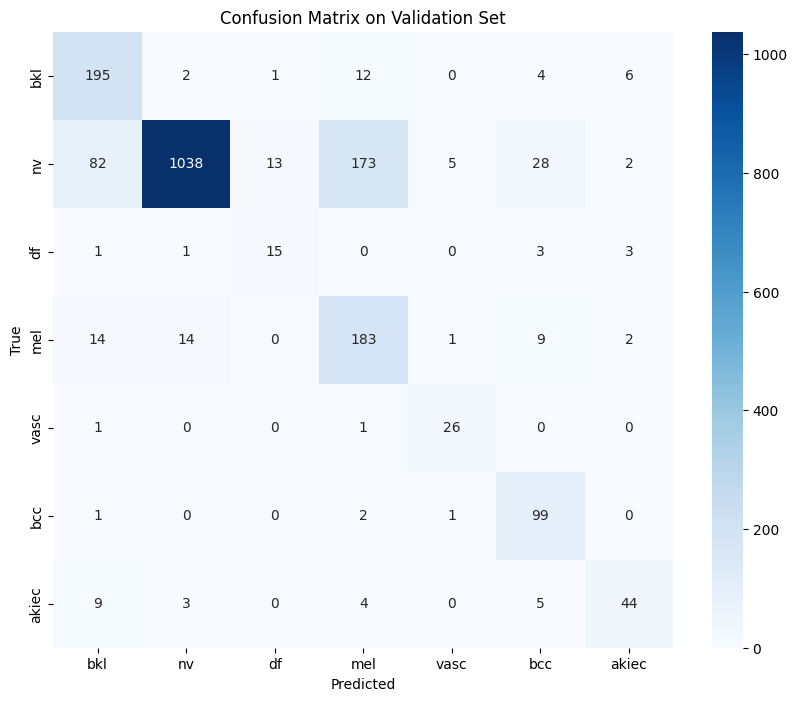

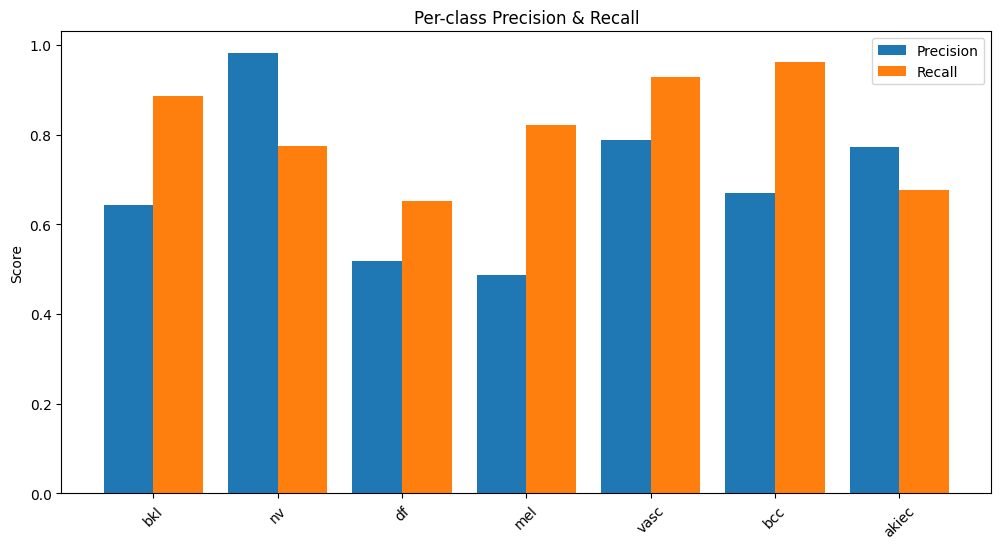

In [65]:
# ========== SAVE STREAMLIT-READY MODEL ==========
final_model_path = os.path.join(SAVE_PATH, "ham10000_best_streamlit.pth")

torch.save({
    "model_state": model.state_dict(),
    "label_map": label_map,
    "idx2label": {v: k for k, v in label_map.items()}
}, final_model_path)

print(f"✅ Final model saved at {final_model_path}")

# ========== CONFUSION MATRIX ==========
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.load_state_dict(torch.load(os.path.join(SAVE_PATH, "best_finetune.pth")))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Validation Set")
plt.show()


# ========== PER-CLASS PRECISION & RECALL ==========
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)

x_labels = list(label_map.keys())
x = np.arange(len(x_labels))

plt.figure(figsize=(12,6))
plt.bar(x - 0.2, prec, width=0.4, label="Precision")
plt.bar(x + 0.2, rec, width=0.4, label="Recall")
plt.xticks(x, x_labels, rotation=45)
plt.ylabel("Score")
plt.title("Per-class Precision & Recall")
plt.legend()
plt.show()
